In [48]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from PIL import Image
import time
import sys
%matplotlib inline

In [13]:
class Network(object):
    
    def __init__(self, layer_node): #layer_node is a list contains the number of nodes in each layer
        self.num_layer = len(layer_node)
        self.layer_node = layer_node
        self.input_node = []
        self.weights = [  np.random.randn(next_node,previous_node+1) for next_node, previous_node in zip(layer_node[1:],layer_node[:-1]) ]
        
    def add_input_node(self,input_vector): #must be of size (n,1)
        if len(input_vector) == self.layer_node[0]: 
            self.input_node = np.append([[1]],input_vector, axis=0) # add bias node
        else:
            print "Input vector length invalid: given len {1}, need len {0}".format(self.layer_node[0], len(input_vector))
            
    def forward_propagation(self):
        output_value = self.input_node
        for weight in self.weights: 
            s = np.dot(weight, output_value)
            output_value = np.append([[1]], activation_function(s), axis=0) # add bias node -> size (n+1,1)
        return output_activation_function(output_value[1:][0][0]) # we omit the bias node 
        
    def backpropagation(self,input_vector, output_vector):
        s = [] # vector before entering node
        x = [np.append([[1]],input_vector, axis=0)] # vector after entering node
        sensitivity = [ np.zeros([1,i]) for i in self.layer_node[1:] ]

        #feedforward, save all the node coefs of each layer
        for weight in self.weights:
            s.append(np.dot(weight, x[-1]))
            x.append(np.append([[1]], activation_function(s[-1]), axis=0))
        sensitivity[-1] = 2.0*(x[-1][1:] - output_vector)*(1-np.square(x[-1][1:])) # omit the bias node 
        
        #backpropagation, compute sensitivity backward
        for layer_index in xrange(2, self.num_layer):
            w = self.weights[-layer_index+1]            
            sensitivity[-layer_index] = (1-np.square(x[-layer_index][1:]))*(np.dot(w.T,sensitivity[-layer_index+1]))[1:] #excluding the bias componnent which has the index 0 
        return x, sensitivity
    
    def SGD(self, training_data, testing_data, eta, epochs, print_message=True, visualize = True): #stochastic gradient descent
        MSE_list = []
        predicted_result = []
        result_df = None
        for epoch in xrange(epochs): 
            MSE = 0 
            gradient = [np.zeros(w.shape) for w in self.weights]

            for index, row in training_data.iterrows():
                vector = np.array(row).reshape(3,1) 
                input_vector, output_vector = vector[:2], vector[2:]
                x, sensitivity = self.backpropagation(input_vector, output_vector)

                for l in xrange(len(gradient)):
                    #print x[l].shape
                    #print sensitivity[l].shape
                    gradient[l] = np.dot(sensitivity[l],np.transpose(x[l]))
                    self.weights[l] = self.weights[l] - eta*gradient[l]
            
            MSE, predicted_result = self.evaluate(testing_data)
            MSE_list.append(MSE)
     
        if print_message:
            print "MSE = ", MSE_list[-1]
            
        if visualize: 
            result_df = visualization(testing_data,predicted_result, MSE_list)
            
        return MSE_list, predicted_result, result_df
    
    def evaluate(self,testing_data):
        MSE = 0
        predicted_result = []
        for index, row in testing_data.iterrows():
            vector = np.array(row).reshape(3,1) 
            input_vector, output_value = vector[:2], vector[2:]
            self.add_input_node(input_vector)
            predicted_value = self.forward_propagation()
            predicted_result.append(predicted_value)
            MSE += np.square(predicted_value - output_value)
        MSE = float(MSE)/testing_data.shape[0]
        return MSE, predicted_result

            

In [14]:
def activation_function(z):
    return np.tanh(z)

In [15]:
def output_activation_function(z):
    return z # linear regression -> identity function

In [16]:
def convert_to_pixel(oldValue, oldRange, oldMin):
    newRange = 255 
    newMin = 0
    newValue = (((oldValue - oldMin) * newRange) / oldRange) + newMin
    return math.ceil(newValue)

def visualization(df, predicted_result, MSE): 
    data = df.copy()
    data['Predicted'] = predicted_result
    new_value = data['Value'].apply(convert_to_pixel, args=(1,0))
    
    min_predicted = data['Predicted'].min()
    max_predicted = data['Predicted'].max()
    
    new_predicted = data['Predicted'].apply(convert_to_pixel, args=(max_predicted-min_predicted,min_predicted))
    data.Value = new_value
    data.Predicted = new_predicted
    
    plt.plot(MSE)
    plt.title('MSE plot')
    
    data.plot(kind='scatter',x='x',y='y',c='Value', title="True Plot")
    data.plot(kind='scatter',x='x',y='y',c='Predicted', title="Predicted Plot")
    
    plt.show()
    return data

#### Create dataframe

In [17]:
def str_to_float(df): 
    new_df = df.copy()
    return new_df.applymap(lambda x: float(x.replace(',','.')))

In [18]:
def z_score(df):
    new_df = df.copy()
    new_df.x = (new_df.x - new_df.x.mean())/new_df.x.std(ddof=0)
    new_df.y = (new_df.y - new_df.y.mean())/new_df.y.std(ddof=0)
    return new_df

In [19]:
def create_df(file_name): 
    df = pd.read_csv(file_name, sep=' ', header=None)
    df.columns = ['x','y','Value']
    df = str_to_float(df)
    df = z_score(df)
    return df 

In [20]:
df = create_df(file_name="donneespb3.txt")

MSE =  0.0108298312325


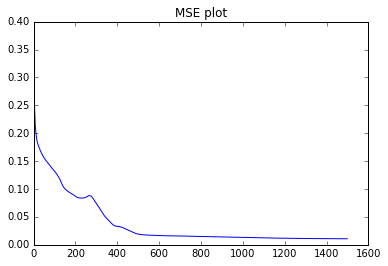

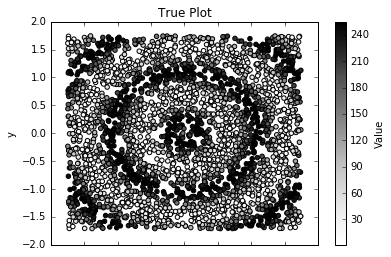

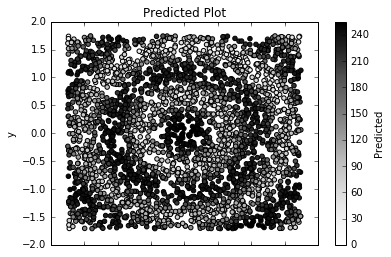

Processing time: 9.14 minutes


In [51]:
neural_net = Network([2,50,1])
t0 = time.clock()
MSE, predicted_result, result = neural_net.SGD(training_data = df, testing_data = df, 
                                             eta = 0.01, epochs = 1500)
print "Processing time: {0:.2f} minutes".format((time.clock() - t0)/60)

#### However, above we have used training data as testing data, and that did not reflect the quality of our model. The neural network is known for its overfitting problem, thus the low MSE received above is not trustworthy. 
#### We will now use cross-validation to assess our model.

In [22]:
from sklearn.cross_validation import KFold

In [23]:
df = create_df(file_name="donneespb3.txt")

In [39]:
def kfold_neural_net(neural_net, n_folds, data, eta, epochs, print_message=True):
    kf = KFold( n=data.shape[0], n_folds=n_folds, shuffle=False,random_state=None)
    cumulative_MSE = 0
    counter = 1 
    for train_index, test_index in kf:
        net = Network(neural_net)
        train_set = data.iloc[train_index,:]
        test_set = data.iloc[test_index,:]
        if print_message:
            print "----Iteration {0}----".format(counter)
        MSE_list, predicted_result, result_df = net.SGD(training_data = train_set, testing_data = test_set, 
                    eta = eta, epochs = epochs, print_message = print_message,visualize = False)
        cumulative_MSE += MSE_list[-1]
        counter += 1
        if print_message: 
            print
        
    average_MSE = cumulative_MSE/float(n_folds)
    if print_message: 
        print "Average MSE = ", average_MSE
    return average_MSE

In [40]:
kfold_neural_net(neural_net = [2,50,1], n_folds = 10, data = df, eta=0.01, epochs = 10)

----Iteration 1----
MSE =  0.217430464239

----Iteration 2----
MSE =  0.265028374068

----Iteration 3----
MSE =  0.178687006273

----Iteration 4----
MSE =  0.233443109394

----Iteration 5----
MSE =  0.247528202519

----Iteration 6----
MSE =  0.210006497081

----Iteration 7----
MSE =  0.277248188042

----Iteration 8----
MSE =  0.257755428922

----Iteration 9----
MSE =  0.235278870974

----Iteration 10----
MSE =  0.141605441528

Average MSE =  0.226401158304


0.2264011583040145

#### Parameter selection

In [41]:
def create_parameter_df(max_learning_rate, min_learning_rate, max_neuron_num, min_neuron_num): 
    learning_rate = np.linspace(min_learning_rate, max_learning_rate, 10)
    neuron_num = range(min_neuron_num, max_neuron_num,10)[1:] #ignore first value, which is 0
    
    learning_rate_lst = []
    for x in xrange(len(neuron_num)):
        learning_rate_lst.extend(learning_rate)
    
    neuron_num_list = []
    for num in neuron_num:
        temp_list = [num] * len(learning_rate)
        neuron_num_list.extend(temp_list)
    
    parameter_df = pd.DataFrame(columns=['Neuron_number','Learning_rate','MSE'])
    parameter_df['Neuron_number'] = neuron_num_list
    parameter_df['Learning_rate'] = learning_rate_lst
    
    return parameter_df

In [42]:
parameter_df = create_parameter_df(max_learning_rate=0.1, min_learning_rate=0.001, max_neuron_num=55, min_neuron_num=0)
parameter_df.head()

,Neuron_number,Learning_rate,MSE
0,10,0.001,NaN
1,10,0.012,NaN
2,10,0.023,NaN
3,10,0.034,NaN
4,10,0.045,NaN


In [43]:
parameter_df.shape

(50, 3)

In [45]:
def parameter_testing(df, parameter_df):
    new_parameter_df = parameter_df.copy()
    min_MSE = np.Inf
    best_row = None
    for index, row in new_parameter_df.iterrows():
        print "Calculating ({0}/{1})...".format(index+1,new_parameter_df.shape[0]) 
        print 
        sys.stdout.flush()
        time.sleep(.2) 
        
        layers = [2,row.Neuron_number,1]
        average_MSE = kfold_neural_net(neural_net=layers, n_folds=10, data=df, eta=row.Learning_rate, epochs= 10, 
                                      print_message=False)
        row.MSE = average_MSE
        
        if average_MSE < min_MSE: 
            min_MSE = average_MSE
            best_row = row 
            print "New best MSE: ",average_MSE
            print "   Number of neurons in the hidden layer: ", row.Neuron_number
            print "   Learning rate: ", row.Learning_rate
            print
        sys.stdout.flush()
        time.sleep(.2) 
    
    print "----------------------------------------------------------"
    print "Best MSE: ",min_MSE
    print "Number of neurons in the hidden layer: ", best_row.Neuron_number
    print "Learning rate: ", best_row.Learning_rate
    print "----------------------------------------------------------"
        
    return new_parameter_df, best_row

In [49]:
t0 = time.clock()
param_df, best_param = parameter_testing(df=df, parameter_df=parameter_df)
print "Processing time: {0} seconds".format((time.clock() - t0))

Calculating (1/50)...

New best MSE:  0.305097552871
   Number of neurons in the hidden layer:  10
   Learning rate:  0.001

Calculating (2/50)...

New best MSE:  0.146944421473
   Number of neurons in the hidden layer:  10
   Learning rate:  0.012

Calculating (3/50)...

Calculating (4/50)...

Calculating (5/50)...

Calculating (6/50)...

Calculating (7/50)...

Calculating (8/50)...

Calculating (9/50)...

Calculating (10/50)...

Calculating (11/50)...

Calculating (12/50)...

Calculating (13/50)...

Calculating (14/50)...

Calculating (15/50)...

Calculating (16/50)...

Calculating (17/50)...

Calculating (18/50)...

Calculating (19/50)...

Calculating (20/50)...

Calculating (21/50)...

Calculating (22/50)...

Calculating (23/50)...

Calculating (24/50)...

Calculating (25/50)...

Calculating (26/50)...

Calculating (27/50)...

Calculating (28/50)...

Calculating (29/50)...

Calculating (30/50)...

Calculating (31/50)...

Calculating (32/50)...

Calculating (33/50)...

Calculating (